In [125]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean
import gudhi as gdh
import sys

In [90]:
number_of_subjects = 73
number_of_readings_per_subject = 1001

In [91]:
# with a certain probability a random generated value will be NaN
def generate_random_value_point(probability):
    if(np.random.random() > probability):
        return np.nan
    elif (np.random.random() > probability * probability):
        return (np.random.random()+1)/4
    #return different random value, else every value close to 1 would be NaN 
    return (np.random.random()+1)/2

#generates random data points randomly ranging from 0.5 to 1 and returns an adequate pandas dataset
def generate_random_data(number_of_subjects, points_per_subject):
    dataset = np.zeros((number_of_subjects, points_per_subject))
    for k in range(number_of_subjects):
        for i in range(points_per_subject):
            r_k_i = generate_random_value_point(probability = 0.89)
            dataset[k][i] = r_k_i

    #set dataset column names (generic)
    data_columns = [f"r_{i}" for i in range(points_per_subject)]
    dataset = pd.DataFrame(dataset, columns = data_columns)
    
    return dataset

In [92]:
dataset = generate_random_data(number_of_subjects, number_of_readings_per_subject)
dataset = dataset.fillna(0.75) # FIX

In [93]:
## determine whether or not the subject is asleep
wake_status = [mean(dataset.iloc[k]) for k in range(number_of_subjects)]
wake_status = ["Awake" if x > 0.75 else "Asleep" for x in wake_status]

dataset["wake_status"] = wake_status

In [94]:
dataset

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,r_992,r_993,r_994,r_995,r_996,r_997,r_998,r_999,r_1000,wake_status
0,0.750000,0.797284,0.750000,0.741840,0.753562,0.605394,0.539986,0.547178,0.699432,0.750000,...,0.567829,0.489908,0.564419,0.750000,0.554830,0.849435,0.827751,0.793622,0.713893,Asleep
1,0.581064,0.785231,0.509145,0.259261,0.750000,0.324162,0.960824,0.674406,0.658971,0.998795,...,0.933867,0.251170,0.701452,0.750000,0.543691,0.893062,0.592791,0.750000,0.445113,Asleep
2,0.786246,0.649006,0.750000,0.555925,0.798370,0.609885,0.743321,0.906690,0.782268,0.988699,...,0.603148,0.844840,0.453371,0.672175,0.860457,0.508361,0.990760,0.625342,0.796762,Asleep
3,0.860637,0.964893,0.688273,0.867915,0.750000,0.676823,0.826033,0.750000,0.893131,0.813951,...,0.536700,0.414219,0.986719,0.838347,0.632063,0.750000,0.600876,0.617534,0.834666,Asleep
4,0.474383,0.595977,0.632382,0.303454,0.997962,0.446635,0.664839,0.742031,0.967370,0.798322,...,0.542018,0.732088,0.320936,0.607256,0.931957,0.997046,0.989464,0.645632,0.921526,Asleep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.750000,0.940874,0.931498,0.566741,0.976897,0.961294,0.352336,0.934273,0.805966,0.841025,...,0.947291,0.666670,0.904671,0.860528,0.763076,0.944201,0.750000,0.505052,0.623854,Asleep
69,0.892954,0.867169,0.761635,0.608804,0.389790,0.516913,0.552092,0.945345,0.750000,0.834957,...,0.862479,0.987754,0.375958,0.419367,0.919427,0.294043,0.724887,0.803596,0.593484,Asleep
70,0.727588,0.737457,0.720338,0.528237,0.496697,0.894042,0.525187,0.426606,0.560797,0.997764,...,0.758670,0.750000,0.826400,0.677856,0.456353,0.750000,0.686385,0.832856,0.885579,Asleep
71,0.318653,0.406674,0.601971,0.719431,0.690721,0.884191,0.633829,0.566906,0.893179,0.642273,...,0.335340,0.368820,0.352124,0.750000,0.742923,0.750000,0.490636,0.750000,0.927164,Asleep


In [95]:
def normalizeDataset(dataset):
    numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        min_val = dataset[col].min()
        max_val = dataset[col].max()
    
        dataset[col] = (dataset[col] - min_val) / (max_val - min_val)
    
    return dataset

In [96]:
dataset = normalizeDataset(dataset)

In [97]:
def createPersistenceDiagram(pointCloud, printGraph = False, memorySaving = True):
    simplex = gdh.RipsComplex(points = pointCloud)
    simplex = simplex.create_simplex_tree(max_dimension = 2)
    barcodes = simplex.persistence()

    if memorySaving:
        simplex = simplex.persistence_intervals_in_dimension(1)
    if printGraph:
        gdh.plot_persistence_diagram(barcodes)

    return simplex

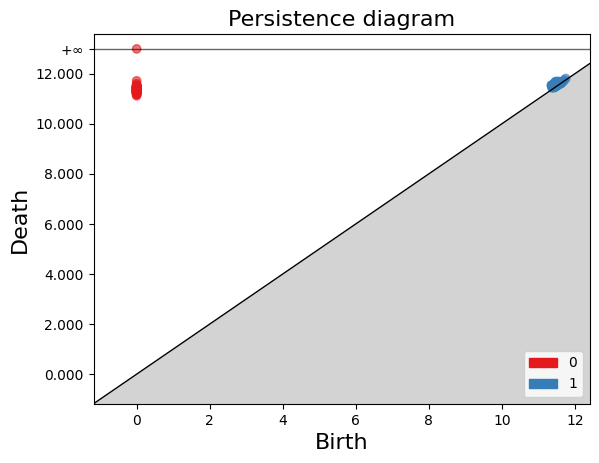

In [98]:
your_data = dataset.drop("wake_status", axis=1)
pointCloud = your_data[0:100]
pointCloud_array = np.array(pointCloud)
example_diagram = createPersistenceDiagram(pointCloud_array, True, True)

In [99]:
def getAllPersistenceDiagrams(dataset, omega, memorySaving = True):
    diagrams = []
    for i in range(len(dataset) - omega):
        pointCloud = np.array(dataset[i:i+omega])
        diagram = createPersistenceDiagram(pointCloud, False, True)
        diagrams.append(diagram)

    return diagrams

In [100]:
probni_dijagram = getAllPersistenceDiagrams(your_data, 7, True)

In [120]:
# for i in range (66):
#     plt.plot(probni_dijagram[i])
#     plt.show()

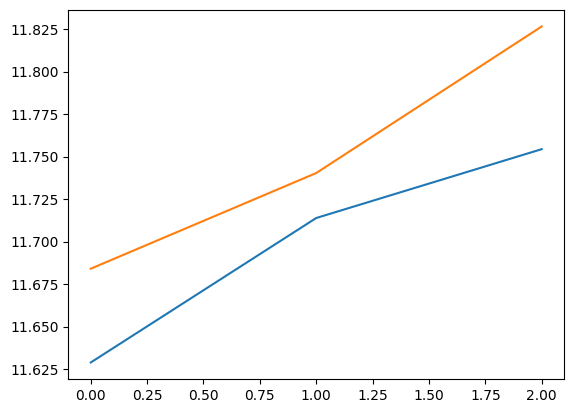

In [115]:
plt.plot(probni_dijagram[35])

In [116]:
def compute_persistence_landscape(
    diagram:            np.ndarray,         # diagram range
    endpoints:          list,               # endpoints
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
) -> np.ndarray:

    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((n_landscapes, resolution))

    diagram_range = endpoints
    x_range =  np.linspace(diagram_range[0], diagram_range[1], resolution)
    step = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = np.zeros([n_landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]

    compute_x_subrange = lambda x: int(np.ceil(x/step))

    for x, y in diagram:
        min_point = x - diagram_range[0]
        mid_point = 0.5*(x+y) - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)

        if minimum_x<resolution and maximum_x>0:
            y_value = diagram_range[0] + minimum_x * step - x
            for i in range(minimum_x, middle_x):
                computed_y_values[i].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x * step
            for i in range(middle_x, maximum_x):
                computed_y_values[i].append(y_value)
                y_value -= step

    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(n_landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = computed_y_values[i][j]
            
    return computed_landscapes_at_given_resolution

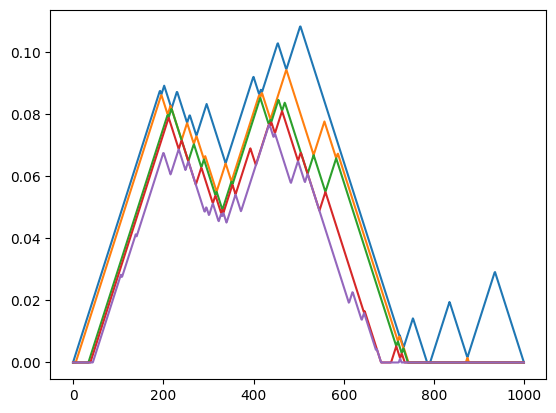

In [117]:
example_landscape = compute_persistence_landscape(example_diagram,[np.min(example_diagram), np.max(example_diagram)], 5, 1000)
plt.plot(example_landscape.T);

In [118]:
def compute_persistence_landscapes(
    diagrams:           np.ndarray,         # diagram D
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = True
) -> np.ndarray:
        
    if memory_saving:
        minp = lambda d: np.min(d) if len(d)>0 else 0
        maxp = lambda d: np.max(d) if len(d)>0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")

    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            n_landscapes,             # m landscapes
            resolution,               # n nodes
        ) for diag in diagrams
    ]
    return landscapes

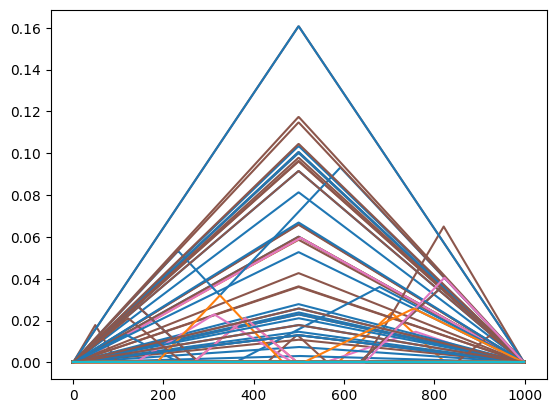

In [121]:
example_landscapes = compute_persistence_landscapes(probni_dijagram, 5, 1000, True)
for l in example_landscapes:
    plt.plot(l.T)

In [122]:
def compute_persistence_landscape_norms(
    landscapes: list
) -> np.ndarray:
    norms_1 = [np.linalg.norm(ls, 1) for ls in landscapes]
    norms_1 = norms_1/(np.linalg.norm(norms_1) + sys.float_info.epsilon)
    
    norms_2 = [np.linalg.norm(ls, 2) for ls in landscapes]
    norms_2 = norms_2/(np.linalg.norm(norms_2) + sys.float_info.epsilon)
    
    return np.array([norms_1, norms_2]).T

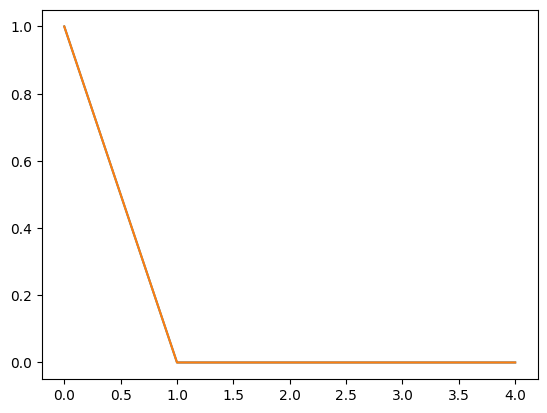

In [126]:
norms_df = compute_persistence_landscape_norms(example_landscapes[0])
df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
plt.plot(df)

In [127]:
n = len(example_landscapes)
norms_dfs = []
for l in example_landscapes:
    norms_df = compute_persistence_landscape_norms(l)
    df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
    norms_dfs.append(df)

L1_norms = np.array([norms_df["L1"] for norms_df in norms_dfs]).T
L1_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

L2_norms = np.array([norms_df["L2"] for norms_df in norms_dfs]).T
L2_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

<Axes: >

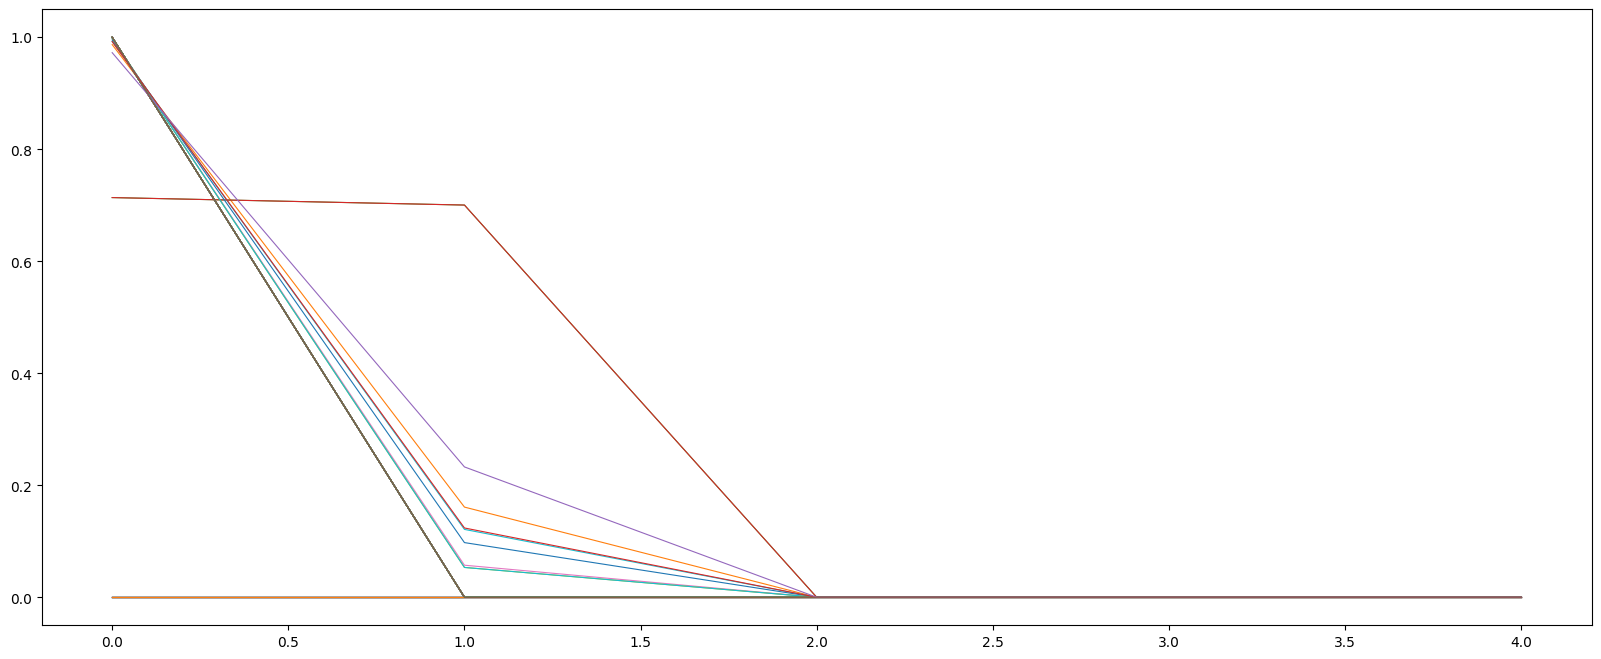

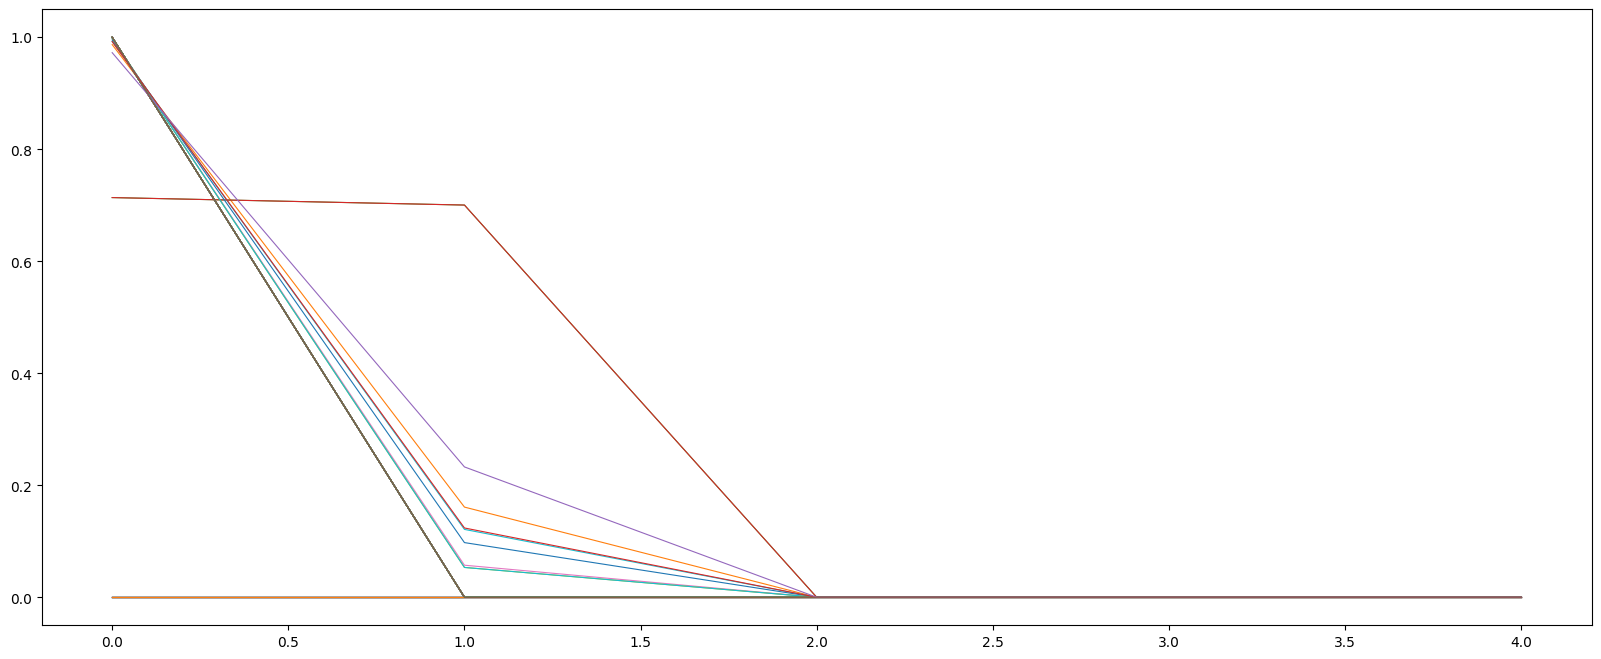

In [131]:
L1_norms.plot(figsize = (20, 8), lw = 0.8, legend = [])
L2_norms.plot(figsize = (20, 8), lw = 0.8, legend = [])

<Axes: >

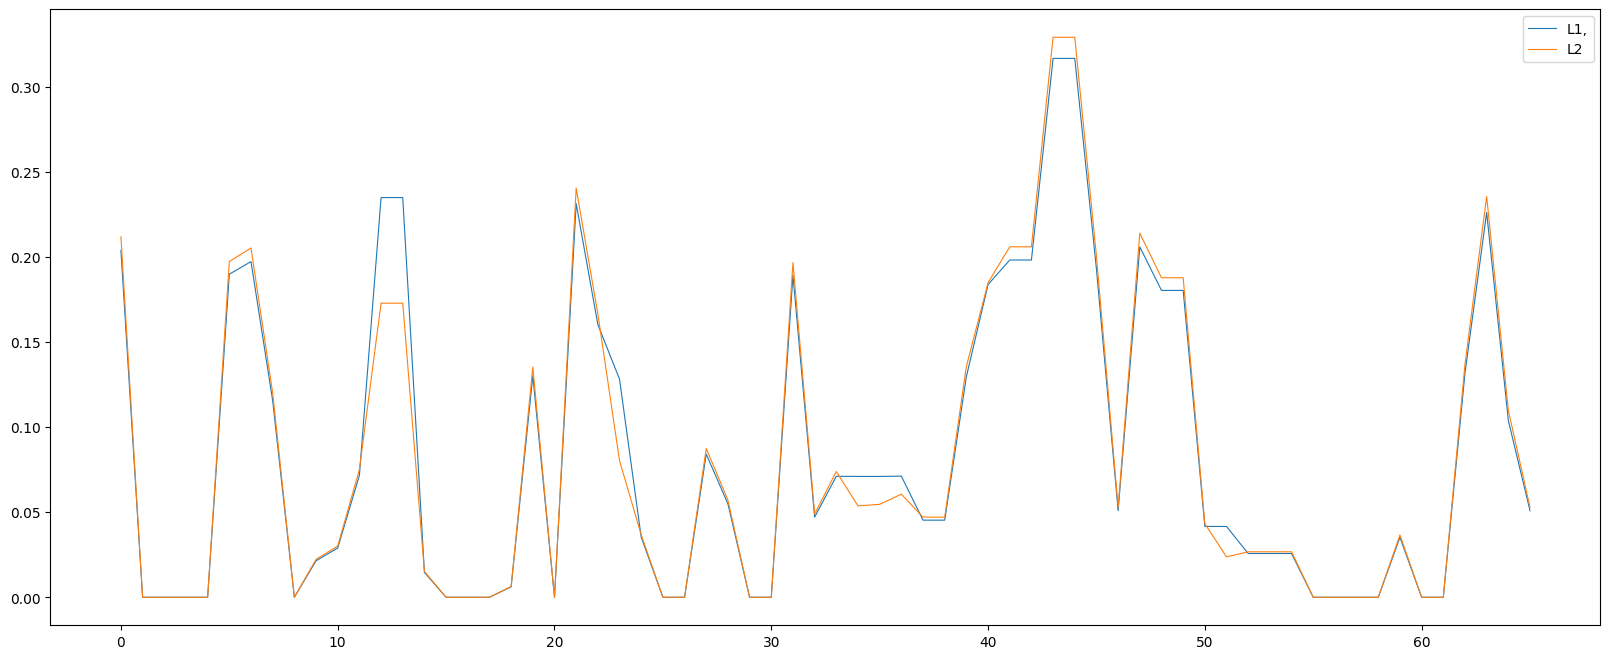

In [129]:
norms_df = compute_persistence_landscape_norms(example_landscapes)
df = pd.DataFrame(norms_df, columns = ["L1,", "L2"])
df.plot(figsize = (20, 8), lw = 0.8)